# 1. Train your own MolMetaLM (optional)

## 1.1 prepare your dataset for pretraining.

## 1.2 pretrain MolMetaLM

In [1]:
!python pretrain_MolMetaLM.py --maxSteps 1000 --warmupSteps 100 --dataset ./datasets/smiles.txt --model_size base

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
2024-09-30 17:09:37.365895: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 17:09:38.978285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/mnt/rna01/wuyf/anaconda3/lib/python3.11/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading some 

# 2. Use MolMetaLM for downstream applicaitons

## 2.1 via scripts

In [ ]:
# molecular representation
!python molecule_embedding.py --input_file ./datasets/smiles.txt --output_file ./cache/smiles.pkl

In [ ]:
# molecular generation based on query molecule
# param method: `structure` for query molecular backbone-based generation; `fingerprint` for query molecular fingerprint-based generation
!python molecule_generate_based_on_query.py --input C --output ./cache \
                                            --method structure --topK 10

In [ ]:
# finetune MolMetaLM for MoleculeNet classification tasks. 
# param datasets: UniMol_PCBA,UniMol_MUV,UniMol_HIV,UniMol_BACE,UniMol_BBBP,UniMol_Tox21,UniMol_ToxCast,UniMol_SIDER,UniMol_ClinTox
!python -u finetune_main_final.py --datasets "UniMol_BBBP" \
                                  --taskType "classification" --modelType "llama2-base"

In [ ]:
# finetune MolMetaLM for GPCR-related activity or AGBT's regression tasks. 
# param datasets: GPCR_5HT1A,GPCR_5HT2A,GPCR_AA1R,GPCR_AA2AR,GPCR_AA3R,GPCR_CNR2,GPCR_DRD2,GPCR_DRD3,GPCR_HRH3,GPCR_OPRM,
#                 AGBT_LD50,AGBT_IGC50,AGBT_LC50,AGBT_LC50DM,AGBT_LogP,AGBT_FreeSolv,AGBT_Lipophilicity
!python -u finetune_main_final.py --datasets "GPCR_5HT1A" \
                                  --taskType "regression" --modelType "llama2-base"

## 2.2 via codes

In [95]:
def analysis_property_from_string(s):
    res = re.findall('(\[RDKit:[0-9a-zA-Z]*?\][0-9.\s]+?);', s)
    return res
def analysis_property_form_mol(m, s):
    func = [re.findall('\[RDKit:(.*?)\]', i)[0] for i in analysis_property_from_string(s)]
    res = []
    for f in func:
        if f in descriptors:
            res.append( f"[RDKit:{f}] "+" ".join(list(f"{getattr(Descriptors, f)(m):.3f}")))
        else:
            print('fk', f, '!!!')
            print(1/0)
    return res

In [297]:
# from huggingface
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained('wudejian789/MolMetaLM-base')
descriptors = [i[7:-1] for i in tokenizer.get_vocab().keys() if i.startswith('[RDKit:')]
model = AutoModelForCausalLM.from_pretrained('wudejian789/MolMetaLM-base').cuda()
model = model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# from your own MolMetaLM
from utils import *
from DL_ClassifierModel import *

collater = HuggingfaceNoisingCollateFunc_final(bertDir='./bertModel/Tokenizer_final', seqMaxLen=512, k=64)
descriptors = collater.DescriptorsAttrs
tkn2id = collater.tokenizer.get_vocab()

config = AutoConfig.from_pretrained("./bertModel/cus-llama2-base", trust_remote_code=True, use_flash_attention_2=True)

backbone = MolMetaLM(config, tkn2id, maxGenLen=512).cuda()
model = HuggingfaceSeq2SeqLanguageModel(backbone, collateFunc=collater, AMP=True)

model.load('./saved_models/MolMetaLM_base_0.842.pkl')

tokenizer = collater.tokenizer
model = model.model

In [120]:
# molecular embedding
smi = "COc1cc2c(cc1OC)CC([NH3+])C2"
tokenized_smi = tokenizer(" ".join(list(smi)), return_token_type_ids=False, 
                          return_tensors='pt', max_length=512, padding='longest', truncation=True)
emb_smi = model.model(**tokenized_smi).last_hidden_state
print(emb_smi.shape) # batch size, seq length, embedding size

torch.Size([1, 27, 768])


generated smiles: c1cc2c(cc1)c1c(cccc1)n2-c1ccc(cc1)N(c1ccc(-c2ccccc2)cc1)c1ccc2c(c3ccccc3c3c2cccc3)c1
properties: ['[RDKit:NumAromaticRings] 1 0 . 0 0 0', '[RDKit:MolWt] 6 3 6 . 7 9 8']


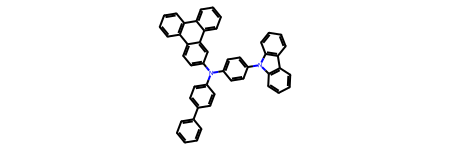

In [116]:
# molecule conditional generation
source = ["[sGLM_smi] [SPAN] [SEP] [RDKit:NumAromaticRings] 1 0 . 0 0 0 ; [RDKit:MolWt] 6 3 6. 0 0 0 ; [SOS]"]
batch = tokenizer(source, return_tensors='pt', max_length=512, padding='longest', truncation=True, return_token_type_ids=False)
target_pre = tokenizer.batch_decode(model.generate(**batch, max_length=512))[0]
smiles = target_pre[target_pre.find('[SOS]')+6:target_pre.find('[EOS]')-7].replace(' ','')
mol = Chem.MolFromSmiles(smiles)
print("generated smiles:",smiles)
print('properties:', analysis_property_form_mol(mol, source[0]))
mol

In [540]:
# molecular optimization
from rdkit import DataStructs
ref_smi = "O=C(N[C@@H](C(=O)[O-])c1ccccc1)C1CCC(CNC(=O)[C@@H]2Cc3ccccc3C[NH2+]2)CC1"
ref_mol = Chem.MolFromSmiles(ref_smi)
proList = ["MolLogP","qed","TPSA"] # target property list you want to optimize 
valList = [-1.0,-0.1,10]           # value difference list you want to change
k = 4                              # factor parameter to control the similarity

pros = [f"[RDKit:{i}]" for i in proList]
vals = [" ".join(list(f"{i:.3f}")) for i in valList]
otherCons = [f"[RDKit:{i}]" for i in descriptors if i not in proList]

while True:
    smi_local = Chem.MolToSmiles(ref_mol, doRandom=True)
    source = "[sPGLM_smi(PAIR)] [SMILES] [SUB] [SPAN] [SEP]" + " ".join([f"{p} {v} ;" for p,v in zip(pros,vals)]) + " ".join([f"{p} 0 . 0 0 0 ;" for p in random.sample(otherCons,k)]) + " [SOS]"
    batch = tokenizer([source.replace('[SMILES]', " ".join(list(ref_smi)))], return_token_type_ids=False, 
                      return_tensors='pt', max_length=collater.seqMaxLen, padding='longest', truncation=True)
    batch = dict_to_device(batch, 'cuda')
    target_pre = tokenizer.batch_decode(model.generate(**batch, max_length=1024, 
                                                       do_sample=True, no_repeat_ngram_size=6, num_beams=5, length_penalty=0))[0]
    smi_opted = target_pre[target_pre.find('[SOS]')+6:target_pre.find('[EOS]')-7].replace(' ','')
    mol_opted = Chem.MolFromSmiles(smi_opted)
    if mol_opted is not None:
        break
fp1 = AllChem.GetMorganFingerprintAsBitVect(ref_mol, 2, nBits=2048, useChirality=False)
fp2 = AllChem.GetMorganFingerprintAsBitVect(mol_opted, 2, nBits=2048, useChirality=False)
sim = DataStructs.TanimotoSimilarity(fp1, fp2)

print(f'original smiles:       ', ref_smi)
print(f'new smiles (sim={sim:.3f}):', smi_opted)

for pro in proList:
    func = getattr(Descriptors, pro)
    print(pro, ':', func(ref_mol)-func(mol_opted))

original smiles:        O=C(N[C@@H](C(=O)[O-])c1ccccc1)C1CCC(CNC(=O)[C@@H]2Cc3ccccc3C[NH2+]2)CC1
new smiles (sim=0.140): c1cc(cc(c1)C(=O)N1CCCC1C(O)=O)NC(c1occc1)=O
MolLogP : -2.0163999999999955
qed : -0.3358734436409784
TPSA : 15.090000000000018


In [301]:
# Note: the length of the structural sequence of large molecules will be too large, beyond the preset sequence length of 512. 
#       therefore, the current model is very unstable when predicting conformation for big molecules (whose num of atoms>20).
# molecular conformation prediction
stType = "AAD"
smi = "C[N@H+]1[C@@H]2[C@H](O)[C@H]1[C@@H]1N[C@@H]12"
mol = Chem.MolFromSmiles(smi)
print('num of atoms:', len(mol.GetAtoms()))
source = [f"[SPM_{stType}] {' '.join(list(smi))} [SEP] {' '.join(['[('+stType+')ATOM:'+a.GetSymbol()+'] [XYZ] ;' for a in mol.GetAtoms()])} [SOS]"]
batch = tokenizer(source, return_tensors='pt', max_length=512, padding='longest', truncation=True, return_token_type_ids=False)
batch = dict_to_device(dict(**batch), 'cuda')
target_pre = tokenizer.batch_decode(model.generate(**batch, max_length=512, do_sample=False,
                                                   num_beams=1, no_repeat_ngram_size=0))[0]

sIdx,eIdx = target_pre.find('[SOS] [SEP]')+12,target_pre.find('[EOS]')
tmp = [[float(j) for j in i.split(',')] for i in target_pre[sIdx:eIdx].replace(' ','').split(';')[:-1]]
xyzArr_pre = xyzDecode(np.array(tmp), stType=stType, eps=1e-8) # , eps=-1
with open('./cache/conformation_pre.mol', 'w') as f:
    s = Chem.MolToMolBlock(mol)
    xyzList = re.findall("([-\s][0-9]+\.[0-9]+)", s)
    start = 0
    for xyz,xyz_ in zip(xyzList,xyzArr_pre.reshape(-1)):
        assert len(xyz)>=7
        l = len(xyz)
        idx = s[start:].find(xyz) + start
        xyz_ = f"{xyz_:10.4f}"[-l:]
        c = len(xyz_) - l
        s = s[:idx-c] + xyz_ + s[idx+l:]
        start = idx+l
    f.write(s)

num of atoms: 9


[22:16:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


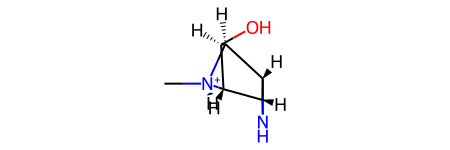

In [303]:
Chem.MolFromMolFile('./cache/conformation_pre.mol')